__Baton Rouge Animal Control and Rescue Center__

_Data obtained from https://data.brla.gov/Public-Safety/Animal-Control-Incidents/qmns-hw3s_

Data contains details of cases taken by Baton Rouge's Animal Control, partnered with and sharing facilities with CAA( Companion Animal Alliance). The Control and Rescue center administers vaccinations, licensing and tags, investigates animal cruelty, dog fighting, and other disturbances. They rescue abandoned animals, sick or injured wildlife and animals owned by those convicted of serious crimes. Educating the public about things such as defense against dog attack, the importance of responsible pet ownership, leash law matters, spay/neuter advantages, etc. are all topics that are offered by the department as well.

For the most part, Baton Rouge actively and successfully takes action to protect animals from people, and people from animals, but issues with animal cruelty and aggressive behavior is still present to a degree. Euthanasia and death rates are rare in this data, but it's unknown what the ultimate resolution if the case is after the animal is transferred to CAA(after the maximum 2-5 day hold), which makes up 70% of the animals in the dataset. Although 38 features are provided, and I've investigated and cleaned all containing at least 1/3 non-nulls, less than half will be of value in further exploration and classification models.

After scrubbing the data, the goal is to investigate as a step in the direction of potentially offering some insight or support to their efforts to improve society's relationship with animals. 

## import

In [1]:
#importing libraries & packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import missingno
import datetime
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import decomposition

Using TensorFlow backend.


In [4]:
# import Animal Control Incidents df
df = pd.read_csv('Animal_Control_Incidents.csv')

## functions

In [4]:
# regex for letters and '/' only, unless pattern reassigned
def remove_numpunc(list, pattern='[^A-Za-z,]+'):
    """regex to apply to list/df column --default: to include only letters and ',' """
    pattern = pattern
    #pattern = '[^A-Za-z_]+'
    if pattern =='[^A-Za-z,]+':
        list = [re.sub(pattern, ',', i) for i in list] 
    if pattern == '[^A-Za-z_]+':
        list = [re.sub(pattern, '', i) for i in list]
    if pattern == '[^A-Za-z/]+':
        list = [re.sub(pattern, '/', i) for i in list]
    if pattern == '[^0-9]+':
        list = [re.sub(pattern, '', i) for i in list]
    return list

In [5]:
# str type, eliminate misplaced whitespace, lower casing, replacing blankspace with '_'
def clean_str(col):
    df[col] = df[col].astype(str, skipna=True)
    df[col] = df[col].str.strip()
    df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
    df[col] = df[col].str.lower()

In [6]:
# plotting counts of timedate data 
def plot_dtcount(td_df, col, limitsy = None, limitsx= None, overlap = True, labels = None, alpha=0.3, size=6):
    """Plots incident count(y) with timeframe as x axis:
    
        td_df = dataframe with date/time
        col = date/time column(s) of dataframe to plot counts
        limitsy= (y,y), limitsx= (x,x) can be adjusted
         -, helful if wanting to exclude extreme outliers -
         overlap= boolean(if looping and want plots seperately plotted, set to False)
         labels= str or list of str for legend
         """
    td_df[col] = td_df[col].dropna()
    time_c = td_df.groupby([col])[col].count()
    
    if limitsy:
        plt.ylim(limitsy)
        
    if limitsx:
        plt.xlim(limitsx)

    if labels:
        plt.legend(
        (labels),
        loc='upper right'
        ,fontsize= 12)
    
    plt.scatter(time_c.index, time_c.values, s= size, alpha=alpha, label=col)
    if not overlap:
        plt.xlabel(col)
        plt.show();

In [7]:
# seaborn correlation plot for categorical data- used for incident counts grouped by datetimes
def corr_plot(data, minv=-.3, maxv=.3, dummy=True):
    """correlation plot:
    
    data= dataframe(will include all columns)
    minv = -float, maxv = float  --adjust closer to 0 for more contrast, closer to -1/1 for less
    dummy = False if df is all numerical. when True:function will only dummy categorical features
    """
    
    if dummy:
        # dummy categorical features
        col_list = list(data.select_dtypes(include=['object']).columns)

        # create dummies for categorical features
        data = pd.DataFrame(pd.get_dummies(data=data,columns=col_list
                       , prefix=col_list))
    sns.set(style="white")
    corr = data.corr()

    # mask the size of covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(corr, mask=mask
                ,annot=False, cmap="YlGnBu", vmin = minv, vmax=maxv, center=0,
                square=True, linewidths=.5,cbar_kws= {"shrink": .5} );
    
    #prevent the shrink of bottom row
    ax.set_ylim(len(data.columns), 0)

In [8]:
#sns countplot loop - probably unnecessary, will replace uses of it in notebook later
def plot_counts(cols):
    for i, col in enumerate(cols):
        plt.figure(i)
        sns.countplot(y=col, data=df);

In [9]:
# replacing strings and substrings FOR COLOR COLUMN ONLY(could be made more universal)
def edit_replace(old_words, replacement_word):
    """simple replacing strings or list in the df.color column since used so frequently in editting"""
    for word in old_words:
        df['color'] = df['color'].apply(lambda x: x.replace(word, replacement_word))

In [51]:
# train and test score, classification report with confusion matrix
def model_report(model): 
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))

    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))
   
    cv_score = np.mean(cross_val_score(model, X, y, cv=3))
    print("cross val score: {:.4}%".format(cv_score * 100))

    print("\nClassification Report:")
    print(classification_report(actuals, predictions))
        
    col_list = []
    ind_list = []                     

    for x in y_train.unique():
        col_list.append('pred_'+ x)
        ind_list.append('real_'+x)        

    print('\nConfusion matrix:'.format(accuracy_score))
    display(pd.DataFrame(confusion_matrix(y_test, predictions)
                             , columns=reversed(col_list), index=reversed(ind_list)))

In [34]:
def plot_feats(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), (X.columns.values)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(25).plot(kind='barh');
    plt.show();

In [15]:
#confusion matrix
def plot_matrix(classifier):
    disp = plot_confusion_matrix(classifier, X_test, y_test,
    #                                  display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
    plt.show();

# __Cleaning__

### overview

looking at size, data types, 'na's

In [13]:
df.shape

(73303, 38)

In [14]:
df.head()

,FILE NUMBER,INCIDENT DATE,INCIDENT TIME,DISPATCHED TIME,CALL TAKER,DISPATCHER,DISPATCHED OTHER,DISPATCHED SITUATION,ARRIVAL TIME,AVAILABLE TIME,...,CONDITION,TEMPERMENT,COLLAR,COLLAR COLOR,VACCINATION NUMBER,VACCINATION DATE,PET NAME,DISPOSITION,DISPOSITION DATE,DISPOSITION OFFICER
0,201639027,12/27/2016,15:30,16:06,UNKNOWN,JENNIFER G,0,D,16:17,16:38,...,FAIR,FRIENDLY,NYLON,RED,NaN,NaN,NaN,TRANS CAA,12/27/2016,FRANK S
1,201639044,12/28/2016,10:06,10:07,UNKNOWN,JENNIFER G,0,D,10:15,10:23,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/28/2016,TRAVIS R
2,201639036,12/28/2016,09:03,09:03,UNKNOWN,JENNIFER G,0,D,09:27,09:45,...,EMACIATED,FRIENDLY,LEATHER,PINK,NaN,NaN,NaN,TRANS CAA,12/28/2016,ISAAC S
3,201639042,12/28/2016,09:46,10:24,UNKNOWN,JENNIFER G,0,D,10:35,10:47,...,EMACIATED,FRIENDLY,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,JOHN B
4,201639059,12/28/2016,15:05,15:45,UNKNOWN,JENNIFER G,0,D,16:07,16:25,...,EMACIATED,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,SUE H


lower casing the column names and replacing whitespace:

In [15]:
# removing spaces and lower casing the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73303 entries, 0 to 73302
Data columns (total 38 columns):
file_number             73303 non-null int64
incident_date           73303 non-null object
incident_time           72818 non-null object
dispatched_time         62547 non-null object
call_taker              53134 non-null object
dispatcher              60239 non-null object
dispatched_other        73303 non-null int64
dispatched_situation    62537 non-null object
arrival_time            61843 non-null object
available_time          62545 non-null object
complainant_street      73281 non-null object
request_type            40141 non-null object
officer                 61235 non-null object
equipment_number        60251 non-null object
remarks                 2098 non-null object
impound_number          53110 non-null float64
impound_date            53105 non-null object
impound_time            53046 non-null object
location                52867 non-null object
municipality       

Although most features are classified appropriately, some of these columns would probably be better dtyped as object than int or float. There are also many dates and times to convert to datetime.  A lot of nulls.

Checking for duplicates:

In [17]:
# any duplicate rows?
print (len(df[df.duplicated(keep='first')])/len(df))
df[df.duplicated(keep=False)]

0.003396859610111455


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
36519,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36520,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36738,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36739,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36862,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36863,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36864,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36865,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
37062,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1
37063,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1


.03% of rows is an insignificant amount of data appearing to be duplicates, so I will remove.

In [18]:
# removing duplicate rows from df - data entry mistakes?
df.drop_duplicates(keep='last', inplace=True)

According to the data source, file numbers should all be unique to each incident. Repeated file numbers could be duplicates of the same incident with benign differences/errors. If there's not an overwhelming amount of entries with duplicate file number, incident date and incident time, I would consider removing the duplicates.

In [19]:
# duplicate file numbers could also indicate duplicates with minor indiscretions 
print (len(df[df.duplicated(subset=['file_number','incident_date', 'incident_time'], keep=False)])/len(df))
df[df.duplicated(subset=['file_number', 'incident_date', 'incident_time'], keep=False)]

0.19540340022449149


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
11,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
16,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
25,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
36,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
69,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
72,201639000,12/27/2016,09:59,10:00,UNKNOWN,JENNIFER G,0,D,10:06,10:15,...,GOOD,FRIENDLY,SPIKE,SILVER,NaN,NaN,NaN,TRANS CAA,12/27/2016,JOHN B
95,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
100,201639000,12/27/2016,09:59,10:00,UNKNOWN,JENNIFER G,0,D,10:06,10:15,...,FAIR,FRIENDLY,SPIKE,SILVER,NaN,NaN,NaN,TRANS CAA,12/27/2016,JOHN B
128,201639121,12/30/2016,08:42,09:28,UNKNOWN,JENNIFER G,0,D,09:36,09:47,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/30/2016,LW
135,201639122,12/30/2016,10:15,10:35,UNKNOWN,JENNIFER G,0,D,10:40,10:50,...,EMACIATED,NERVOUS,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/30/2016,JASON C


_I wasn't confident in my decision to remove such a fraction of data, but after coming across  unexplained duplicates of impound numbers and other curious things, I decided it would be more harmful to keep_

In [20]:
# # this should drop duplicate file number rows, keeping the row with the lease nas
df = df.loc[df.notnull().sum(1).groupby(df.file_number).idxmax()]
df.drop_duplicates(subset=['file_number'], keep='last', inplace=True)

How much nas per column are there?

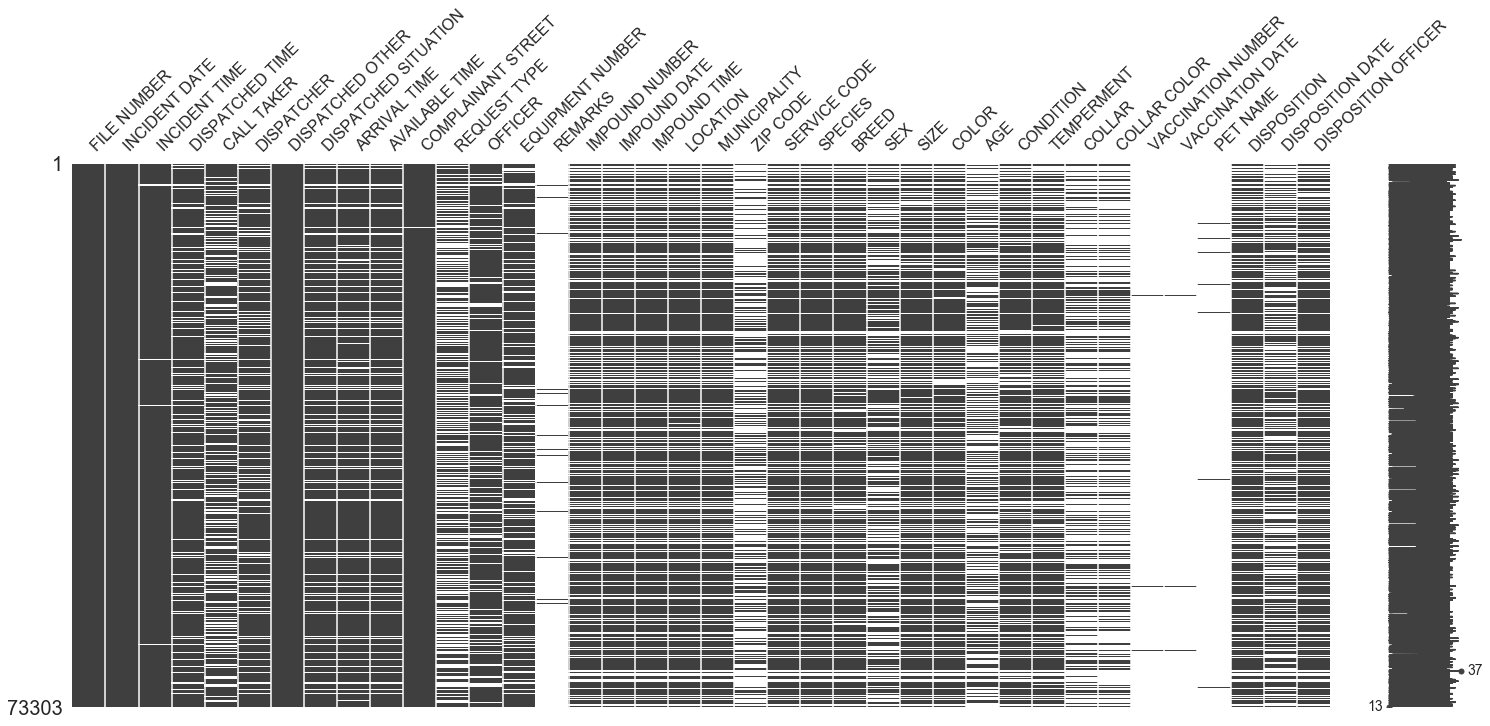

In [9]:
missingno.matrix(df.sort_values(by=['INCIDENT DATE']));

In [21]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

file_number              0.0
incident_date            0.0
incident_time            1.0
dispatched_time         13.0
call_taker              28.0
dispatcher              16.0
dispatched_other         0.0
dispatched_situation    13.0
arrival_time            14.0
available_time          13.0
complainant_street       0.0
request_type            43.0
officer                 17.0
equipment_number        16.0
remarks                 98.0
impound_number          32.0
impound_date            32.0
impound_time            32.0
location                32.0
municipality            32.0
zip_code                69.0
service_code            32.0
species                 32.0
breed                   33.0
sex                     48.0
size                    33.0
color                   33.0
age                     57.0
condition               35.0
temperment              34.0
collar                  68.0
collar_color            68.0
vaccination_number      99.0
vaccination_date        99.0
pet_name      

Since most features are missing substantial amounts of data, I want to be careful about dropping nas to avoid tossing out useful information with the nulls.

Vaccination number, vaccination date, remarks, and pet name are all missing 98-99% data.  Collar color and collar might be interesting to look at if focus was on something dog related that it may have some relevance to, but I'm wanting to keep a more inclusive approach, and don't see the purpose of collar information. Since other species are included in the data, the collars are probably only seen on cats and dogs for the most part.



*_I can only speculate the reasons for the amount of missing data. However, I found the lack of impound date/time, was in fact due to the cases not resulting in impounding._

In [22]:
# removing columns with 90%+ missing:
df.drop(columns=['remarks', 'vaccination_number', 'vaccination_date', 'collar', 'collar_color', 'pet_name'
                ,'file_number']
        , inplace=True)

In [23]:
#removing row with nas from incident time since such little nas(1% rows)
df = df[df['incident_time'].notna()]

In [24]:
df3= df.copy()

### unimportant?

I'll start by investigating the features I anticipate are not going to be useful or might have too many nas.

#### age, sex

age missing 57%, sex missing 48%

In [25]:
df.age.value_counts()/df.age.value_counts().sum()

0.0     0.995113
2.0     0.000992
3.0     0.000735
5.0     0.000698
4.0     0.000441
1.0     0.000367
6.0     0.000257
9.0     0.000220
8.0     0.000220
10.0    0.000184
7.0     0.000184
13.0    0.000147
12.0    0.000110
11.0    0.000073
14.0    0.000073
16.0    0.000073
15.0    0.000073
17.0    0.000037
Name: age, dtype: float64

Not sure about 99% of the animals being 0 years old, it could be a default in data entry. I will be excluding this column, although it would be nice to have had that information.

In [26]:
df.drop(columns=['age'], inplace=True)

In [27]:
df.sex.value_counts()/df.sex.value_counts().sum()

M    0.352181
U    0.351216
F    0.296362
1    0.000060
D    0.000060
K    0.000030
S    0.000030
0    0.000030
N    0.000030
Name: sex, dtype: float64

In [28]:
for x in ('l','D', 'K', '0', 'N', 'S', '1'):
    df['sex'] = df['sex'].replace(x, np.NaN)

The sexes appear mostly balanced between Male, Female, and Unidentified. I'm not sure what the other letters represent. I probably won't be using this feature because of missing data and having 35% unidentified.

In [29]:
# df.drop(columns=['sex'], inplace=True)

#### names

In [30]:
name_cols = ['call_taker', 'dispatcher', 'officer', 'disposition_officer'] 

In [31]:
# cleaning name cols
for col in name_cols:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')        

In [32]:
for col in name_cols:
    df[col].value_counts()

unknown       28129
nan           17415
jennifer_g     5920
bc             2411
john_b         1076
bg              884
tr              830
is              758
daniel_p        660
jc              649
tz              558
jb              532
jtg             488
sb              452
jg              408
tp              401
sedwin_b        373
rt              360
fs              198
law             188
ms              160
wb              129
richard_b       103
ac               81
rosemary_a       54
lw               49
sr               43
dp               36
sh               33
joey_g           30
ic               29
sw               14
jpb              13
jason_c           8
                  8
sue_h             7
isaac_s           6
travis_r          5
frank_s           4
jeg               4
jw                3
anna_c            3
mg                3
bjg               2
tf                2
djp               1
jeb               1
aa                1
llaw              1
ttr               1


jennifer_g    33323
bc            17200
nan            9800
unknown         859
john_b          745
richard_b       722
sedwin_b        600
jtg             138
joey_g          131
bg                5
is                4
rt                2
isaac_s           1
tp                1
passpp            1
                  1
Name: dispatcher, dtype: int64

nan           10674
unknown        9012
frank_s        4167
anna_c         3774
travis_r       3249
jason_c        2994
tr             2943
john_b         2766
jb             2609
bg             2544
sue_h          2415
isaac_s        2116
sb             1764
sedwin_b       1737
lw             1219
is              818
fs              778
jc              675
jtg             656
tz              604
allison_c       599
dd              576
jennifer_g      494
tp              453
mg              451
jg              434
rt              401
jw              337
kd              311
joey_g          295
              ...  
sh               33
hilton_c         31
sw               17
jpb              13
brent_g          11
                  5
hc                5
bc                5
jeg               4
susan_w           4
suzie_b           3
kjg               2
bjg               2
btg               2
kjc               1
ab                1
abg               1
dfs               1
ng                1


nan           20739
sw            15510
sb             4469
ph             2763
frank_s        2104
anna_c         2063
jl             1998
travis_r       1681
john_b         1498
jason_c        1402
allison_c      1241
lw             1206
sue_h          1136
sedwin_b       1044
isaac_s        1033
jtg             809
dd              680
kd              420
djp             262
jw              204
joey_g          133
tim_z           129
bg              100
tr               97
jg               87
tp               82
rt               80
is               79
jb               65
susan_w          55
              ...  
ms               40
kw               35
patty_h          28
suzie_b          12
hilton_c          8
ic                7
law               5
rosemary_a        4
jennifer_g        3
dp                2
richard_b         2
bmg               2
swi               2
ab                2
bjg               1
pj                1
pl                1
mg                1
yr                1


I'm not sure how useful this inf

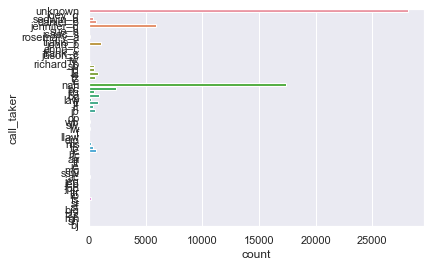

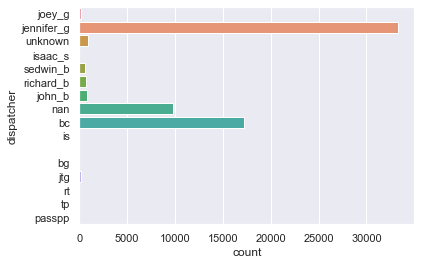

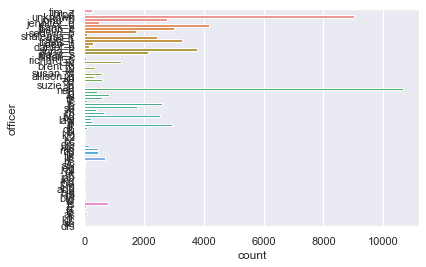

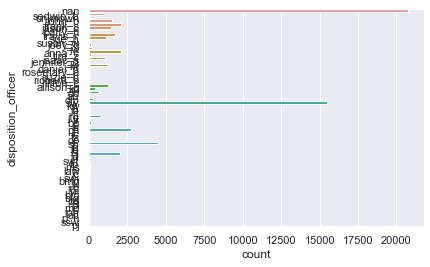

In [33]:
plot_counts(name_cols)



If I was able to consult someone of knowledge at the baton rouge animal control facility, I would be able to sort out the names better(i.e. are any of the initials representative of the given full names). I looked at the staff directory on their website but only found two names listed, and aren't present in the dataset. It was for the director and 'cat in tree complaints'.

This information doesn't seem important enough to include, and is also a little messy for me to navigate without having more information on the staffing of the animal control officers and call takers.

In [34]:
# df.drop(columns = name_cols, inplace=True)

#### equipment number

ID of the vehicle sent to the incident location

In [35]:
df.equipment_number.value_counts()

AC04     5555
AC12     5380
AC09     5378
AC13     4850
AC10     4409
AC06     4270
AC11     4198
AC19     4039
AC18     3386
AC01     3249
AC16     3124
AC15     2493
AC14     1466
AC20      186
19        115
12        100
AC9        77
15         77
4          73
AC6        71
11         62
10         59
13         58
14         55
09         50
AC4        49
9          41
1          37
AC05       37
16         36
         ... 
06         14
AC 19      13
04         11
AC 9       10
AC 4        9
AC 1        7
AC08        7
AC 18       6
AC 8        6
AC 13       5
AC 6        5
AC 14       4
18          4
AC 12       3
5           3
AC 20       3
17          3
AC-14       2
AC5         2
AC-10       1
AC-4        1
AC016       1
AC- 4       1
AC 15       1
2692        1
4C18        1
SC          1
AC198       1
AC 7        1
ZAC14       1
Name: equipment_number, Length: 67, dtype: int64

removing all non digit characters, and removing the beginning 0

In [36]:
# removing characters, and 0s in front of values
clean_str('equipment_number')

df['equipment_number'] = remove_numpunc(df['equipment_number'], pattern ='[^0-9]+')

df['equipment_number'] = df['equipment_number'].apply(lambda x : x[1:] if x.startswith("0") else x)

replacing the out of bounds numbers with Nan, replacing the '4C18' value, which I have assumed was intended to be AC18. Also, replacing the values that had no digits with NaN.

In [37]:
# replacing odd values wih nans, or other assumed value
df['equipment_number'] = df.equipment_number.replace('2692', 'nan')
df['equipment_number'] = df.equipment_number.replace('198', 'nan')
df['equipment_number'] = df.equipment_number.replace('418', '18')
df['equipment_number'] = df['equipment_number'].apply(lambda x : x.replace(x,'nan') if x=='' else x)

df.loc[df['equipment_number'] == 'nan', 'equipment_number'] = np.NaN

In [38]:
df.equipment_number.value_counts()

4     5699
9     5556
12    5483
13    4913
10    4484
6     4393
11    4282
19    4167
18    3397
1     3344
16    3161
15    2571
14    1528
20     189
5       42
7       35
17      28
8       13
Name: equipment_number, dtype: int64

#### impound_number

Number used to track animals being impounded into shelter.

In [39]:
df.impound_number.value_counts()

0.0        19
28919.0     2
40362.0     2
38399.0     2
22119.0     2
38496.0     2
36297.0     2
35637.0     2
52488.0     2
41801.0     2
24164.0     2
23618.0     2
28289.0     2
59335.0     2
35672.0     2
53435.0     2
25162.0     2
24290.0     2
26970.0     2
59854.0     2
20057.0     2
27535.0     2
42765.0     2
63752.0     2
20866.0     2
53254.0     2
24181.0     2
24905.0     2
35080.0     2
24267.0     2
           ..
87692.0     1
54733.0     1
36692.0     1
79165.0     1
94646.0     1
59045.0     1
93373.0     1
90066.0     1
22195.0     1
81436.0     1
21095.0     1
88590.0     1
90065.0     1
79171.0     1
79071.0     1
59834.0     1
87682.0     1
28260.0     1
79170.0     1
50134.0     1
48477.0     1
23373.0     1
38116.0     1
79169.0     1
63986.0     1
51065.0     1
21568.0     1
88576.0     1
79168.0     1
90112.0     1
Name: impound_number, Length: 43264, dtype: int64

0.0 values are being reassigned to NaN

Although many of these were transferred to the animal shelter, the record fails to show unique impound numbers for them.

In [40]:
# replacing '0.0' impound with NaT
df.loc[df['impound_number'] == 0.0, 'impound_number'] = np.NaN

In [41]:
#print (len(df[df.duplicated(subset=['file_number','incident_date'], keep=False)])/len(df))
df[df.duplicated(subset=['impound_number'], keep=False)]

,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,...,species,breed,sex,size,color,condition,temperment,disposition,disposition_date,disposition_officer
28371,05/02/2016,06:03,08:52,unknown,joey_g,0,D,09:07,09:17,AVENUE C ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
28329,05/02/2016,06:04,09:18,unknown,joey_g,0,D,09:33,09:51,TRUMAN ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
28277,05/02/2016,06:06,08:26,unknown,joey_g,0,D,08:45,08:53,CHARLES ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3060,05/02/2016,06:15,00:00,unknown,joey_g,0,K,00:00,00:00,HUNTERS TRAIL DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
28255,05/02/2016,06:18,09:51,unknown,joey_g,0,D,10:09,10:11,SAUL AV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
2196,05/02/2016,06:19,13:38,unknown,joey_g,0,D,14:34,14:34,WILLIAMS RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
28251,05/02/2016,06:23,08:27,unknown,joey_g,0,D,08:47,08:51,PLAZA DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3050,05/02/2016,06:23,10:14,unknown,joey_g,0,D,10:14,10:33,O'NEAL LN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3168,05/02/2016,06:24,08:39,unknown,joey_g,0,D,08:45,08:48,PLANK RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
891,05/02/2016,07:28,08:28,unknown,joey_g,0,D,08:58,09:10,ORLANDO DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


I don't notice any rows that look similar enough to be considered duplicates. However, I also don't see this feature being useful for me.

In [42]:
df.drop(columns=['impound_number'], inplace=True)

#### dispatched situation, dispatched other

- __dispatched situation:__ Indicates if officer was dispatched (D) or the call had to be postponed (K) and addressed the following day. ( _data source does not explain U,F, or N_ )


- __dispatched_other:__ Not dispatched by cad but there is dispatch info in record



In [43]:
for col in ('dispatched_situation', 'dispatched_other'):
    df[col].value_counts()

D    51144
K     4566
U      155
F        5
N        1
Name: dispatched_situation, dtype: int64

0    62337
1     1196
Name: dispatched_other, dtype: int64

In [44]:
# replacing unknowns with na
for word in ('U','F', 'N'):
    df['dispatched_situation'] = df['dispatched_situation'].replace(word, np.NaN)

I probably won't be using these features in the model, but the dispatched situation is something I might come back to in future wrk

In [45]:
# # won't be needing these
# df.drop(columns=['dispatched_situation', 'dispatched_other'], inplace=True)

### service code, request type (service_type)

Request type is the type of incident being reported, and similarly, service code is used at the responding officer's discretion. There may be some differences, but hoping they're similar enough to merge into one feature to avoid covariance. 

In [46]:
sr = ('service_code', 'request_type')

In [47]:
for col in sr:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Service_code --
 TRAPPED ANIMAL           16258
STRAY                     6696
STRAY AN. SECURED         3701
STRAY AN SECURED          2186
LOOSE                     2082
INJURED                   1931
OWNER SIGNED RELEASE      1443
ABANDONED ANIMAL          1236
WILD LIVE                 1220
BITE CASE LOOSE            845
SICK ANIMAL                779
UNIT STANDING BY           775
ANIMAL RESCUE              723
CRUELTY                    597
VET PICKUP                 509
BITE CASE SECURE           427
DANGEROUS ANIMAL SIT.      353
SNAKE                      334
DANGEROUS ANIMAL SIT       278
SCHOOL CALL                242
LOOSE LIVESTOCK            240
UNKNOWN                    228
SPECIAL CASE               132
BITE CASE                  107
DOG FIGHTING                13
OWNED                        4
HIT BY CAR                   1
Name: service_code, dtype: int64 

-- Request_type --
 UNKNOWN                       6405
TRAPPED ANIMAL                5737
STRAY             

In [48]:
#fixing service codes

def rename_code(word, new):
    df.loc[df['service_code'] == word, 'service_code'] = new

#stray
rename_code('STRAY AN. SECURED', 'STRAY')
rename_code('STRAY AN SECURED', 'STRAY')
#dangerous
rename_code('DANGEROUS ANIMAL SIT', 'DANGEROUS')
rename_code('DANGEROUS ANIMAL SIT.', 'DANGEROUS')
#bite
rename_code('BITE CASE LOOSE', 'BITE CASE')
rename_code('BITE CASE SECURE', 'BITE CASE')
#wildlife
rename_code('WILD LIVE', 'WILD LIFE')
#others
rename_code('UNKNOWN', np.NaN)
rename_code('OTHER', np.NaN)
#abandoned
rename_code('ABANDONED ANIMAL', 'ABANDONED')

In [49]:
# fixing request types

def rename_type(word, new):
    df.loc[df['request_type'] == word, 'request_type'] = new
#stray    
rename_type('STRAY ANIMAL SECURED', 'STRAY')
rename_type('STRAY ANIMAL', 'STRAY')
#dangerous
rename_type('DANGEROUS ANIMAL SITUATION', 'DANGEROUS')
#school
rename_type('ANIMAL ON SCHOOL CAMPUS', 'SCHOOL CALL')
#others
rename_type('UNKNOWN', np.NaN)
rename_type('OTHER', np.NaN)
#abandoned
rename_type('ABANDONED DOG', 'ABANDONED')

rename_type('CRUELTY RECHECK', 'RECHECK')

In [50]:
# cleaning up service code and request type
for col in ('service_code', 'request_type'):
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')
    df.loc[df[col] == 'nan', col] = np.NaN

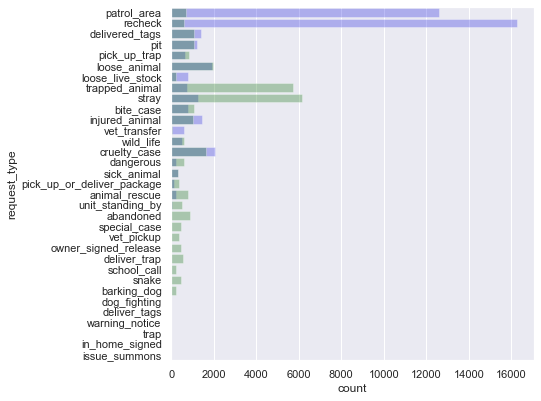

In [51]:
# common values of service code and request type
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.countplot(y='service_code', data=df, color='blue', alpha=.3)
sns.countplot(y='request_type', data=df, color='green', alpha=.3);

In [52]:
# re-categorizing/merging similar service types

for word in ('dog_fighting', 'dangerous', 'bite_case'):
    df['service_code'] = df['service_code'].replace(word, 'bite_dangerous')
    df['request_type'] = df['request_type'].replace(word, 'bite_dangerous')
    
for word in ('issue_summons', 'in_home_signed', 'warning_notice', 'special_case', 'deliver_tags', 'trap'):
    df['service_code'] = df['service_code'].replace(word, 'other')
    df['request_type'] = df['request_type'].replace(word, 'other')
    
for word in ('loose_animal', 'loose_livestock', 'wild_life', 'stray', 'loose', 'loose_live_stock'):
    df['service_code'] = df['service_code'].replace(word, 'loose_stray')
    df['request_type'] = df['request_type'].replace(word, 'loose_stray')
    
for word in ('injured_animal', 'vet_transfer', 'sick_animal', 'injured', 'vet_pickup', 'hit_by_car'):
    df['service_code'] = df['service_code'].replace(word, 'sick_inj')
    df['request_type'] = df['request_type'].replace(word, 'sick_inj')

for word in ('cruelty', 'cruelty_case', 'abandoned', 'animal_rescue'):
    df['service_code'] = df['service_code'].replace(word, 'cruelty')
    df['request_type'] = df['request_type'].replace(word, 'cruelty')
    
for word in ('owned', 'owner_signed_release'):
    df['service_code'] = df['service_code'].replace(word, 'owned')
    df['request_type'] = df['request_type'].replace(word, 'owned')
    
for word in ('patrol_area', 'recheck', 'unit_standing_by'):
    df['service_code'] = df['service_code'].replace(word, 'patrol')
    df['request_type'] = df['request_type'].replace(word, 'patrol')

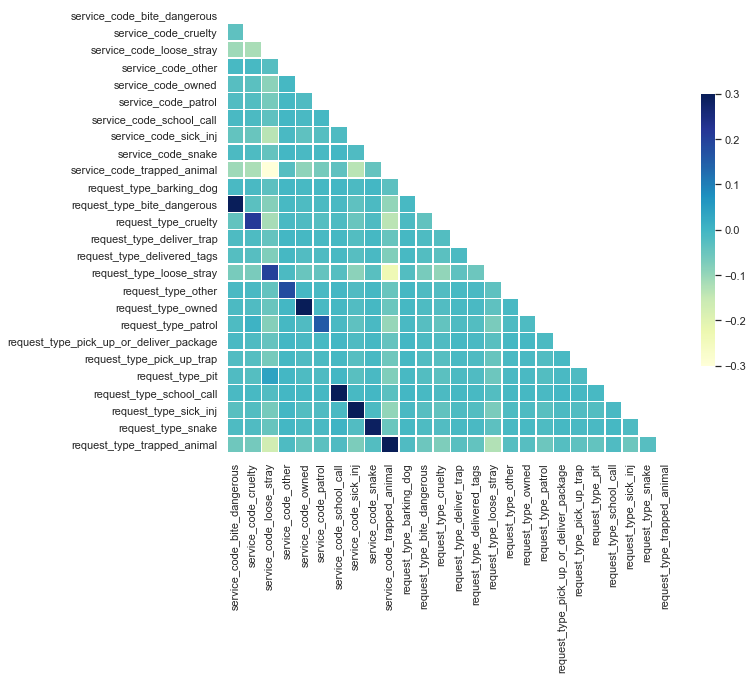

In [53]:
sr_df = df[['service_code', 'request_type']]
corr_plot(sr_df)

In [54]:
# creating column that fills in missing values from service code using existing values from request type
df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

# dropping merged columns
df.drop(columns=['service_code', 'request_type'], inplace=True)

In [55]:
# removing punctuations, lower casing, etc..
clean_str('service_type')
df['service_type'] = remove_numpunc(df['service_type'], pattern='[^A-Za-z_]+')

In [57]:
df.service_type.value_counts()

loose_stray                   20650
trapped_animal                16716
nan                            5706
cruelty                        4941
sick_inj                       3794
bite_dangerous                 3015
patrol                         2149
owned                          1534
delivered_tags                 1065
pick_up_trap                    786
snake                           673
pit                             626
other                           514
deliver_trap                    479
pick_up_or_deliver_package      350
school_call                     334
barking_dog                     201
Name: service_type, dtype: int64

### date & time

Converting dates and times to appropriate format.


#### datetime: incident and impound

- Merging incident date and time to datetime column, repeat with impound date & time.

In [59]:
# incident date + incident time for merged datetime column
df['inc_dt'] = pd.to_datetime(df['incident_date'].apply(str)+' '+df['incident_time'])

# impound date + impound time = impound datetime
df['imp_dt'] = pd.to_datetime(df['impound_date'].apply(str)+' '+df['impound_time'], errors ='coerce')

In [60]:
#assigning NaT to out of bounds dates and times
for col in ('inc_dt', 'imp_dt'):   
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

df = df.sort_values(by='inc_dt')
df.reset_index(drop=True, inplace=True)

In [61]:
df.head()

,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,...,size,color,condition,temperment,disposition,disposition_date,disposition_officer,service_type,inc_dt,imp_dt
0,01/01/2012,11:20,NaN,jg,nan,0,NaN,NaN,NaN,CHEVELLE,...,LARGE,YELLOW/RED,FAIR,FRIENDLY,TRANS CAA,01/01/2012,sw,loose_stray,2012-01-01 11:20:00,2012-01-01 11:20:00
1,01/01/2012,14:12,NaN,is,nan,0,NaN,NaN,NaN,SHERWOOD,...,SMALL,GRY/WHT,FAIR,NORMAL,TRANS CAA,01/01/2012,sw,bite_dangerous,2012-01-01 14:12:00,2012-01-01 14:12:00
2,01/01/2012,15:4,NaN,is,nan,0,NaN,NaN,NaN,RICHMOND,...,LARGE,WHT/BRINDLE,FAIR,DANGEROUS,TRANS CAA,01/01/2012,sw,bite_dangerous,2012-01-01 15:04:00,2012-01-01 15:04:00
3,01/01/2012,16:51,NaN,jb,nan,0,NaN,NaN,NaN,STEARNS,...,MEDIUM,GOLD/BLK,GOOD,FRIENDLY,TRANS CAA,01/14/2012,sw,trapped_animal,2012-01-01 16:51:00,2012-01-14 16:51:00
4,01/02/2012,8:34,NaN,jg,nan,0,NaN,NaN,NaN,SUNSET,...,MEDIUM,BLACK,FAIR,NERVOUS,TRANS CAA,01/02/2012,sw,trapped_animal,2012-01-02 08:34:00,2012-01-02 08:34:00


####  Time Features:

In [62]:
# time columns to list, then loop conversion to date.time
time_cols= [col for col in df.columns if 'time' in col]

# covert time to hour/minute datetime format
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', format="%H:%M").dt.time

In [63]:
for col in time_cols:
    df[col].value_counts().head(10)

08:10:00    521
08:08:00    519
08:11:00    518
08:09:00    516
08:12:00    480
08:13:00    441
08:07:00    433
08:14:00    424
08:15:00    393
08:17:00    366
Name: incident_time, dtype: int64

00:00:00    4630
09:16:00     263
09:22:00     258
09:17:00     252
09:20:00     248
09:21:00     245
09:19:00     242
09:15:00     237
09:23:00     236
09:11:00     235
Name: dispatched_time, dtype: int64

00:00:00    5642
09:21:00     259
09:22:00     251
09:23:00     244
09:19:00     242
09:20:00     240
09:25:00     238
09:13:00     238
09:16:00     237
09:24:00     237
Name: arrival_time, dtype: int64

00:00:00    4638
09:16:00     269
09:23:00     263
09:13:00     262
09:14:00     258
09:25:00     255
09:21:00     252
09:22:00     251
09:20:00     246
09:19:00     243
Name: available_time, dtype: int64

09:00:00    261
10:00:00    253
09:30:00    238
09:15:00    220
10:30:00    211
09:20:00    209
09:10:00    195
14:00:00    179
09:45:00    174
10:50:00    173
Name: impound_time, dtype: int64

there's consistently high counts around 8-10ish, although impound times highest look a little more 
The 00:00:00 is probably the default, not actual times, so I will replace with NaT.

In [64]:
# replacing '00:00:00' with NaT
for col in time_cols:
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT

In [65]:
print('Incident time Range:\n''from',df.incident_time.min(),'\n to:', df.incident_time.max())

Incident time Range:
from 00:04:00 
 to: 23:58:00


####  Date Features:

In [66]:
# all date columns to list
date_cols= [col for col in df.columns if 'date' in col]

In [67]:
# covert to month/day/year datetime format
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors='coerce', format="%m/%d/%Y")

In [68]:
for col in date_cols:
    df[col].value_counts().head()
    df[col].value_counts().tail()

2017-07-17    114
2016-11-14    114
2017-05-30    110
2016-05-31    107
2018-01-16    104
Name: incident_date, dtype: int64

2019-03-24    1
2015-06-20    1
2012-01-21    1
2013-12-25    1
2016-06-25    1
Name: incident_date, dtype: int64

2013-10-17    49
2013-12-02    43
2014-06-23    42
2013-10-14    41
2013-06-10    41
Name: impound_date, dtype: int64

2014-11-23    1
2017-11-25    1
2015-06-13    1
2016-07-17    1
2019-04-27    1
Name: impound_date, dtype: int64

2013-10-17    45
2013-12-02    43
2013-10-14    42
2014-06-23    42
2013-06-10    41
Name: disposition_date, dtype: int64

2016-12-03    1
2018-02-08    1
2017-10-09    1
2018-09-18    1
2017-02-12    1
Name: disposition_date, dtype: int64

In [69]:
# date range of dataset
print('Incident Date Range:\n''from:',df.incident_date.min(),'\n to:', df.incident_date.max())

Incident Date Range:
from: 2012-01-01 00:00:00 
 to: 2019-10-03 00:00:00


I noticed some dates were entered as older than 2012,or newer than 2019 which I assume was a mistake. 

In [70]:
#dates out of range to NaT
for col in date_cols:
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

#df.loc[df['impound_date'] < '2012-01-01 00:00:00 ']

In [71]:
for col in date_cols:
    df.loc[df[col] > '2019-10-04 00:00:00 ', col] = pd.NaT

#### additional time features:

In [73]:
# dealing with extreme time values and 0s
for col in ('inc_dt', 'imp_dt'):   
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

___
Weekday and Month:

This may not provide anything insightful, but I'm creating columns for weekday and month of incident.

__- Weekday Feature-__

In [74]:
# creating day of week column:
df['weekday'] = pd.to_datetime(df['impound_date']).apply(lambda x: x.weekday())

df.weekday.value_counts()
# 0= monday

0.0    8329
2.0    7869
1.0    7856
3.0    7727
4.0    7224
5.0    2417
6.0    1902
Name: weekday, dtype: int64

It looks like most incidents occur on Mondays, and then dwindle down throughout the week, with much less incidents reported on weekends

Are the amount of impounds per day relative to the amount of incidents?

In [75]:
# how does incident day of week compare to impound day of week?:
imp_weekday_counts=(pd.to_datetime(df['incident_date'].dropna()).apply(lambda x: x.weekday()).value_counts())
(imp_weekday_counts.sum())/(df.weekday.value_counts().sum())
imp_weekday_counts/df.weekday.value_counts()
# 0= monday

1.466462007201551

0    1.689639
1    1.564027
2    1.505147
3    1.489194
4    1.457364
5    0.760861
6    0.764984
dtype: float64

Something seems strange here. The dataframe has 76% of total not-null impounds to total incidents, why would there be 30% more impounds than incidents on any of the days, especially weekends?

___
__- Month feature-__

In [76]:
# column for month
df['month'] = pd.DatetimeIndex(df['impound_date']).month

df.month.value_counts()

6.0     4161
7.0     4135
8.0     4094
5.0     4056
9.0     3968
10.0    3957
4.0     3629
3.0     3587
2.0     3092
1.0     3056
11.0    2967
12.0    2622
Name: month, dtype: int64

__Warmer Climate = More Animal Control Incidents__ 

Not a huge surprise, but May-September appear to have the most incidents. According to weather.com, the average temperature increases rises from the 50's to 60's degree Fahrenheit around min April, and then begins to dip below the 60s again towards the end of October(although Baton Rouge typically experiences the most volume in rainfall in June and August). This isn't a real shocker, just an observation confirming what one might already assume.

*_Note that since the dates run between Jan-1-2012 to Oct-3rd-2019, there will be bias. Of course, if this was important to me right now, or becomes important, I would put forth effort reduce the bias._

### animal features

Animals features include __color__, __breed__, __condition__, __temperment__, and __size__. color and breed present an issue with such high unique values for what should be considered , multiple spellings for the same color/breed, and alternate sequences of the same substrings appearing as different values( i.e. brown/white vs white/brown)

#### color

##### unifying spellings of colors

In [77]:
#df.color.value_counts()
df.color.value_counts()

BLK/WHT                  3132
BLK                      3096
GRY                      2904
BRWN/WHT                 1285
GRY/WHT                  1247
TAN/WHT                  1178
TAN                      1122
BRWN                     1109
BLK/TAN                  1037
GRAY                     1011
BROWN                     922
GREY                      903
GRY/BLK                   799
WHT                       696
BLK/GRY                   682
BRWN/BLK                  636
BLK/BRWN                  630
BLACK                     605
BRN/BLK                   600
WHT/BLK                   597
ORG                       540
WHT/BRWN                  522
BRINDLE                   475
BRN                       454
TAN/BLK                   414
WHT/TAN                   403
NORMAL                    373
WHT/GRY                   326
WHITE                     324
YELLOW                    302
                         ... 
gray                        1
BRINDLE/WHT/BLK             1
B ROWN    

Color Feature Cleaning:

- Not liking the all caps, also unnecessary punctuation.


- 1089 unique color values is going to be a problem for machine learning models, so I'd also like to reduce those. Each color needs to have uniform spelling, and combinations with low value counts will be categorized as 'other' to reduce dimensionality and noise.

*_I'll be treating each combination as it's own category. I'm not sure if approaching each color as a separate feature would be practical, but maybe could be given more thought later. I don't see value in each individual color as much as the overall description of color(s) as a whole._

In [78]:
# clean string type
clean_str('color')

df['color'] = remove_numpunc(df.color, pattern = '[^A-Za-z,]+')

By looking at value counts of strings, I can decide which ones need uniform spelling. The ones with higher counts will be prioritized, and some may slip through the cracks, as it is a tedious task. Colors with strong similarity will be placed into major color categories as well, at my discretion.(ie. tan, sandy, and blonde all identified as 'tan') 

##### editting color names

In [79]:
# white: wht
whites = ('white', 'cream', 'whute', 'whit', 'whitg', 'wht','whtie'
          , 'wwht', 'what','wt','whitge','whiite','whute','shite')

edit_replace(whites, 'wht')

# blacks: bl
blacks = ('black', 'blk', 'blkl', 'charcoal', 'bllk', 'balck', 'blavk', 'bkl', 'vlack'
          , 'blavck', 'blkc', 'blakc')

edit_replace(blacks, 'bk')

# browns: br
browns = ('brown','brrwn', 'brwn', 'brn', 'choc', 'chocolate', 'brwon', 'choclate'
          , 'brw', 'brownish', 'brow', 'brnlate', 'brnish', 'brnolate', 'brnm', 'brolate'
          , 'brblk','chestnut', 'cho', 'brrwn', 'bbrown','bown')

edit_replace(browns,'br')

# greys: gry
greys = ('grey', 'gray', 'grrey','greymarble')

edit_replace(greys, 'gry')

# tans/beige/blonde: tn
tans = ('beige', 'blonde', 'golden', 'tan\\', 'goldish', 'tna', 'gold', 'tan', 'taan', 'sandy')

edit_replace(tans, 'tn')

# stripes: stripe_tabby
tabbies = ('tabby','tiger', 'tabble', 'taddy', 'tabs', 'tabbie')

edit_replace(tabbies, 'tab')

# calico = cal
edit_replace(('calico','claico'), 'cal')

# orange: or
oranges = ('orange', 'orn', 'copper', 'orang', 'orage', 'ornage')

edit_replace(oranges, 'org')

# brindle/fawn: brndl
brindles = ('brindle', 'fawn', 'merle', 'torti', 'marbled', 'tortie', 'bridle', 'brndl', 'brndle', 'brndlee','leopard', 'tortoise', 'brindlw', 'brindlde')

edit_replace(brindles, 'bndle')

# yellow: yel
edit_replace(('yellow','yelow','yellw', 'yell', 'ylw'), 'yel')

# stop words and not decribing color (* is there a better way to do this?)
to_drop = ('chest','and', 'normal', 'nose', 'paws', 'mouth', 'with', 'tail'
           , 'belly', 'head', 'ears', 'eyes', 'face', 'feet', 'color', 'standard',
          'fred', 'pattern', 'newbord', 'mostly', 'front', 'all', 'body', 'little', ' ', '  ')

edit_replace(to_drop, '')

##### alphabetizing and 'other' feature for low value counts

In [80]:
df['color'] = [','.join(sorted(i.split(','))) for i in df['color']]

df['color'] = df['color'].apply(lambda x : x[1:] if x.startswith(",") else x)

In [81]:
# defining counts to separate at n value counts(n= arbitrary number)
counts = df['color'].value_counts()

# color combinations with less than n counts will be categorized as 'other'
other_color_df =df[df['color'].isin(counts[counts < 10].index)]

other_color_df['color'] = 'other'

#should be one value: 'other'
other_color_df.color.value_counts()

other    782
Name: color, dtype: int64

In [82]:
# color values with over/equal to n counts
colors_df =df[df['color'].isin(counts[counts >= 10].index)]

#should be n or more per value
colors_df.color.value_counts().tail()

bk,tn,wh       6
marble         6
grywht         6
cal,wht        6
bk,bndle,tn    6
Name: color, dtype: int64

In [83]:
#joining the 'other color' and 'all colors' dfs
df = pd.concat([colors_df,other_color_df ])

In [84]:
# # replacing unknown values, and fixing repeats
df.loc[df['color'] == 'nan', 'color'] = np.NaN
df.loc[df['color'] == 'unknown', 'color'] = np.NaN
df.loc[df['color'] == '', 'color'] = np.NaN
df.loc[df['color'] == 'tn,tn', 'color']='tn'
df.loc[df['color'] == 'wht,wht', 'color'] = 'wht'

In [85]:
#all should have a minimum n value counts, 'other' should now be included
df.color.value_counts()

gry              4832
bk,wht           4459
bk               3713
br,wht           2706
bk,gry           2618
br               2587
bk,br            2549
gry,wht          2400
tn,wht           2144
bk,tn            1854
tn               1368
wht              1094
bk,br,wht         784
other             782
bndle             674
org               633
br,gry            565
bk,tn,wht         560
gry,tn            514
bndle,wht         470
org,wht           364
bk,gry,wht        330
br,tn             317
yel               305
red               274
blue,wht          253
cal               191
bk,gry,tn         150
blue              136
bk,org,wht        129
                 ... 
org,tab,wht         8
bk,br,red           8
org,tn              8
bk,wh               8
br,light            8
bndle,tn,wht        8
blue,br             8
bndle,gry,wht       8
bk,br,tn,wht        8
silver,tn           8
b,w                 8
br,dark             7
br,red,tn           7
bk,gry,org          7
bk,blue,wh

unique values reduced from 1900! there may be some mistakes after all of the editting, and I know there has to be a better way to have done all of that, but still probably worth it.

#### breed

In [86]:
df.breed.value_counts()

DSH                               8648
POSSUM                            5337
PITBULL                           4336
RACCOON                           4250
XPIT BULL                         3345
XLABRADOR                         2106
XTERRIER                          1085
XSHEPHERD                          773
LABRADOR RETRIEVER                 744
PIT                                731
DMH                                664
GERMAN SHEPHERD                    634
DLH                                628
TERRIER                            609
XGERMAN SHEPHERD                   481
XHOUND                             431
SQUIRREL                           393
CHIHUAHUA                          348
OTHER                              308
ARMADILLO                          284
XCHIHUAHUA                         283
SHIH TZU                           270
ROTTWEILLER                        258
HORSE                              253
XROTTWEILER                        227
BOXER                    


*_DSH=Domestic Short Hair, DMH= Domestic Medium Hair, and DLH=Domestic Long Hair_

In [87]:
# remving X from beginnings, cleaning up 
df['breed'] = df['breed'].apply(lambda x : x[1:] if str(x).startswith("X") else x)
# lower casing and '_'
clean_str('breed')
# removing extra '_'s
df['breed'] = df.breed.apply(lambda x: x.replace('__', '_'))
# removing other punctuation
df['breed'] = remove_numpunc(df['breed'], pattern='[^A-Za-z_]+')

*_some of these breeds sound very similar(ie. staffordshire bull terrier vs american staffordshire terrier, doberman vs doberman pinscher, but I have investigated the questionably similar breeds before reassigning to the same variable._

In [88]:
# replacing breed names 
def rep_breed(word, replacement):
    df['breed'] = df['breed'].apply(lambda x: x.replace(word, replacement)) 

# replacing breed names 
rep_breed('chow_chow', 'chow')
rep_breed('boston_terrier', 'boston')
rep_breed('poodle_standard', 'poodle')
rep_breed('basset_hound', 'basset')
rep_breed('rottweiller', 'rott')
rep_breed('rottweiler', 'rott')
rep_breed('pit_bull', 'pitbull')
rep_breed('pitbull', 'pit')
rep_breed('labrador_retriever', 'labrador')
rep_breed('catahoula_hound', 'catahoula')
rep_breed('english_bulldog', 'bulldog_english')
rep_breed('shar_pei', 'sharpei')
rep_breed('brittany_spaniel', 'brittany')
rep_breed('other', 'unknown')


df.loc[df['breed'] == 'nan', 'breed'] = np.NaN

In [89]:
df.breed.value_counts()

dsh                               8648
pit                               8415
possum                            5337
raccoon                           4250
labrador                          2850
terrier                           1694
german_shepherd                   1243
shepherd                           846
dmh                                664
chihuahua                          631
dlh                                628
hound                              537
rott                               485
squirrel                           393
boxer                              385
unknown                            378
armadillo                          284
beagle                             275
shih_tzu                           270
catahoula                          257
horse                              253
chow                               251
dachshund                          199
retriever                          189
mixed                              165
husky                    

#### condition, disposition, size, species, temperament

In [90]:
cdsst ='species', 'size', 'condition', 'temperment', 'disposition'

In [91]:
# cleaning text strings
for col in cdsst:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')

for col in cdsst:
    df.loc[df[col] == 'nan', col] = np.NaN
    df.loc[df[col] == 'unknown', col] = np.NaN

In [92]:
for col in cdsst:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Species --
 dog          21081
wildlife     10867
cat          10097
reptile        401
livestock      323
fowl           203
bird           165
birds          122
other           25
exotic           5
Name: species, dtype: int64 

-- Size --
 medium         19959
large          13314
small           7256
extra_large     1120
Name: size, dtype: int64 

-- Condition --
 fair         28414
good          7036
emaciated     4668
excellent      269
poor           198
Name: condition, dtype: int64 

-- Temperment --
 normal       20298
friendly     10396
nervous       9554
dangerous     1172
scared          25
Name: temperment, dtype: int64 

-- Disposition --
 trans_caa            30826
return_to_wild        9625
return_to_owner       1663
special_caseother      944
euthanized             149
dead_on_arrival         76
Name: disposition, dtype: int64 



In [93]:
# there's so little 'poor' and 'excellent', I've decided to replace them with majority similar descriptors
df["condition"]=df['condition'].replace("poor", 'emaciated')
df["condition"]=df['condition'].replace("excellent", 'good')

df["species"]=df['species'].replace("birds", "bird")

df["temperment"]=df['temperment'].replace("nan", np.NaN)
df["temperment"]=df['temperment'].replace("unknown", np.NaN)

#there's only 24 'scared' cases, and is similar enough to be interpreted as 'nervous'
# ideally I would consult with the animal control facility on how they make assign the temperment
df["temperment"]= df['temperment'].replace("scared", 'nervous')

### location related

The features describing location are: municipality, location, zip code, and complainant street.

The only column without missing values is the street feature. The usefulness of this feature in analysis is questionable, but if enough correlation exists, I could use it to fill in missing data in one of the other features with the most likely value.

In [94]:
loc_cols = ('municipality', 'location', 'zip_code', 'complainant_street')

In [95]:
for col in loc_cols:
    df[col].isna().sum()/len(df)

0.3178820455511309

0.3207309587143689

0.6935136071018211

0.00011017896211417689

In [96]:
for col in loc_cols:
    clean_str(col)

Since I've lower cased everything, I now have to fix the 'nan's. I think there probably is a better way to do it without having to go back and do this, but for now I'm going with it

In [97]:
# since I've lower cased everything, now I have to fix the 'nan's
df.loc[df['zip_code'] == 'nan', 'zip_code'] = np.NaN
df.loc[df['complainant_street'] == 'nan', 'complainant_street'] = np.NaN
df.loc[df['location'] == 'nan', 'location'] = np.NaN

# there seems to be a lot of 'unknown' values in the dataset, it could make things noisy
df.loc[df['zip_code'] == '', 'zip_code'] = np.NaN
df.loc[df['municipality'] == 'unknown', 'municipality'] = np.NaN

In [98]:
for col in loc_cols:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Municipality --
 baton_rouge    39524
nan            20196
parish          1385
zachary          880
baker            762
central          583
Name: municipality, dtype: int64 

-- Location --
 2680_progress               232
9465_goodwood               179
191_lsu                     107
1071_crescent                84
19700_old_scenic             75
6010_huckleberry             60
1657_brocade                 57
3803_sherwood_forest         53
2883_saratoga                51
16352_old_hammond            50
16044_tiger_bend             49
5922_glen_cove               48
1126_sunshine                46
845_wordsworth               43
3445_ozark                   43
1451_great_oak               43
3511_myrtle_grove            42
7489_oakmount                41
15545_old_hammond            40
3144_seneca                  39
16819_cherry_bark            34
8022_antioch                 34
1324_louray                  34
18733_samuels                33
1253_boreas                  32
324

Interesting that there are so many incidents occurring at some of these unique addresses. I'm wondering if this is a case of duplicate rows.


*_After researching, I found this from the ACRC website:
...However, location data regarding where the incident was reported or occurred is included within this data set, which may or may not be the same location as the animal owner's home or property._

complainant street has no nas, but not sure if it provides value to analysis without a region

## __save to csv__

In [100]:
df.to_csv('a_control.csv',index=False)

# __Explore__

Despite my attempts to find correlations and trends, nothing especially interesting came of my explorations. 

### datetime features

#### times

There are 5 different time categories. Their descriptions are self descriptive, although the 'available time' wasn't clear at first. That category marks the time that the responding officer was finished with the incident and once again available.


The facilities are open between 8:00-16:00, but there is an emergency and after hours line that will respond to some excpetions, which would explain the outliers in the early and late hours of dispatch, arrival, and available times.

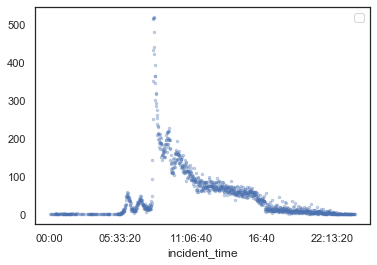

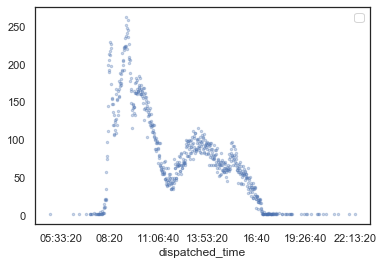

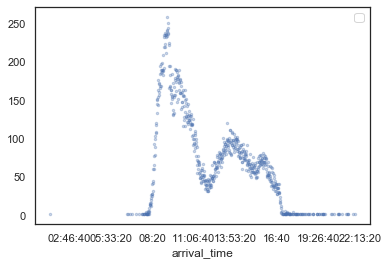

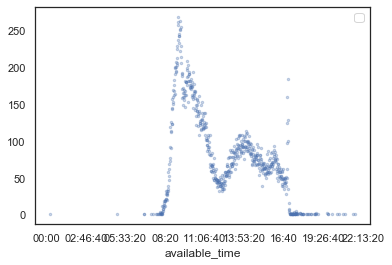

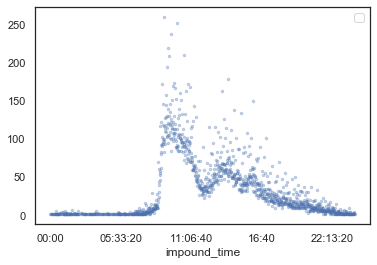

In [101]:
for col in time_cols:
    plot_dtcount(df, col, overlap = False, labels = time_cols)

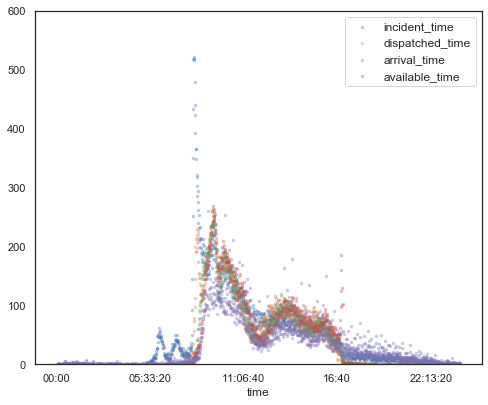

In [102]:
# plotting frequency of each time feature:
f, ax = plt.subplots(figsize=(8, 6.5))
for col in time_cols:
    plot_dtcount(df, col
                 , (0, 600)
                 , labels = time_cols)

Around 9am-ish the incident count reaches a peak, then once again rises between 12pm-4pm, Not seeing anything that would seem out of the ordinary here.

#### dates

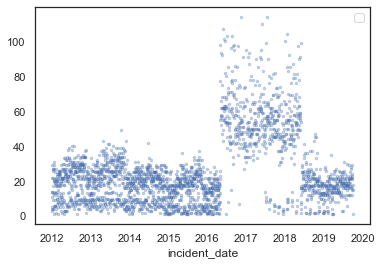

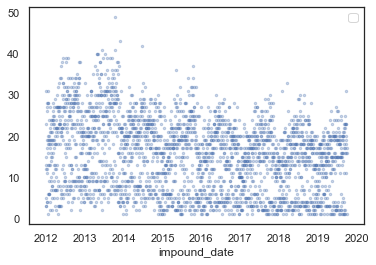

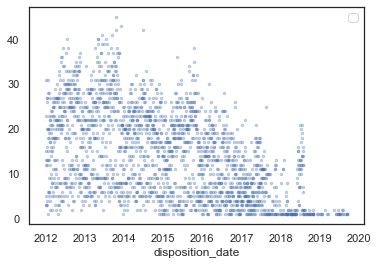

In [103]:
for col in date_cols:
    plot_dtcount(df, col, overlap = False, labels = date_cols)

Why does the disposition date and slightly with impound date decline in incidents?
It's possible that measures have been taken over time to reduce the amount of impounds, but with the disposition date, I'm wondering if the animal control facility just hasn't been consistently filling out that part of the record in the past couple of years.

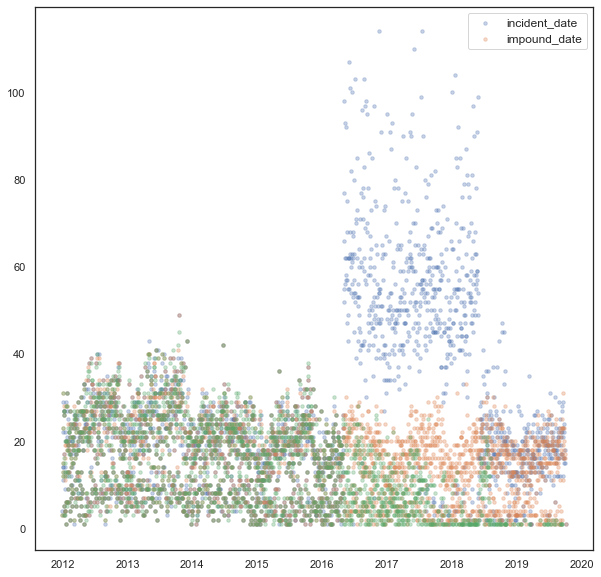

In [104]:
f, ax = plt.subplots(figsize=(10, 10))
for col in date_cols:
    plot_dtcount(df, col, overlap = True, labels = date_cols, alpha=.3, size=12)

I would have expected the disposition date, incident date, and impound date, to have a more positive, collinear relationship throughout the full 8 years of the data, it's strange that after 2016, there's much more irregularities.  The frequency of incident date is so elevated between 2016-1018. It reaches 100 counts some days, but rarely over 40 on the surrounding times. Is this an issue of data management or is there some other reason for this? I'm questioning the reliability of the the date data.

#### trends

##### bite incidents

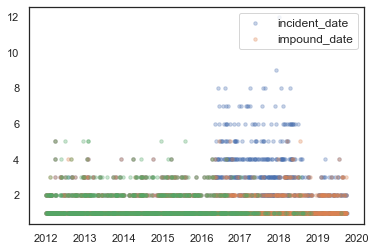

In [105]:
bite_df = df[df['service_type']=='bite_dangerous']

for col in date_cols:
    plot_dtcount(bite_df, col, overlap = True, labels = date_cols, alpha=.3, size=12)

###### __Ignore below__.
___
After trying to look for trends in various conditions, I've given up on using the dates or times to do so. I can't figure out why the dates data is so irregular.  The time data appears normal, but the conditions I looked into were all consistent with the incident counts like you would expect.

In [106]:
euth_df = df[df['disposition']=='euthanized']

friendly_df = df[df['temperment']=='dangerous']

returned_df = df[df['disposition']=='return_to_owner']

dog_df = df[df['species']=='dog']

cruelty_df = df[df['disposition']=='cruelty_case']


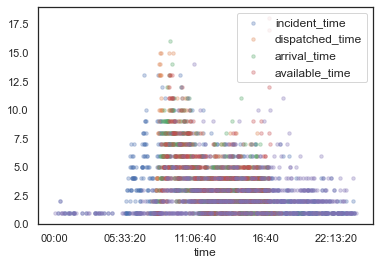

In [107]:
for col in time_cols:
    plot_dtcount(bite_df, col, overlap = True, labels = time_cols, alpha=.3, size=12)   

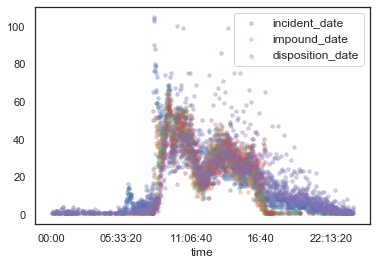

In [108]:
for col in time_cols:
    plot_dtcount(dog_df, col, overlap = True, labels = date_cols, alpha=.3, size=12)  

How do the service types from 2016 on compare to those before 2016

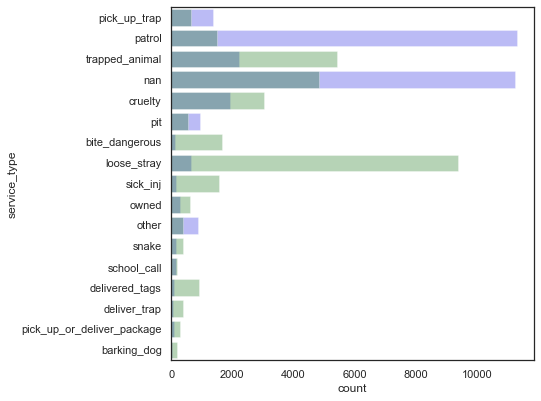

In [109]:
df_pre = df.loc[df['inc_dt'] < '2016-08-12 00:00:00 ']
df_post = df.loc[df['inc_dt']> '2016-08-12 00:00:00']
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.countplot(y='service_type', data=df_pre, color='blue', alpha=.3)
sns.countplot(y='service_type', data=df_post, color='green', alpha=.3);

The first 1/2 incidents are more often patrol and cruelty, and the second half of data is heavier on loose/stray, trapped, and sick/injured.

In [110]:
len(df_pre.isna())
len(df_post.isna())

31664

31869

### animal features 

#### condition, disposition, size, species, temperment

In [111]:
#value counts of species, size, condition, and temperment features
ssct_df = df[['species', 'size', 'condition', 'temperment', 'disposition']]

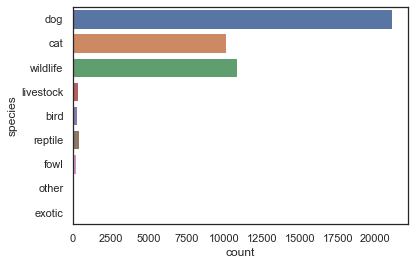

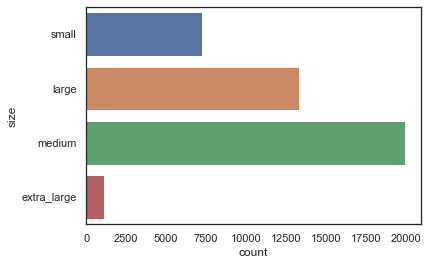

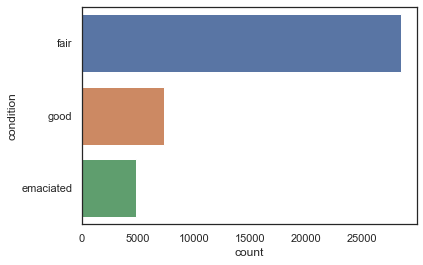

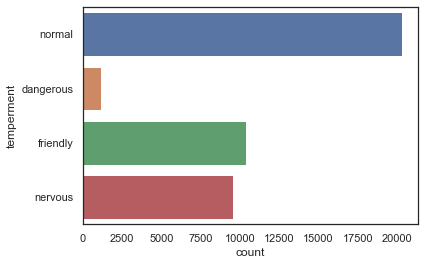

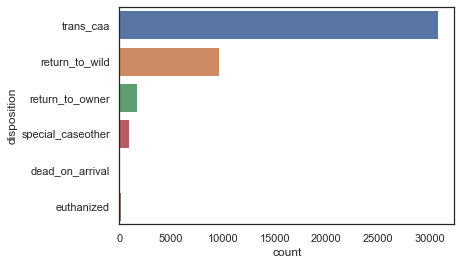

In [112]:
plot_counts(ssct_df)

#### correlations

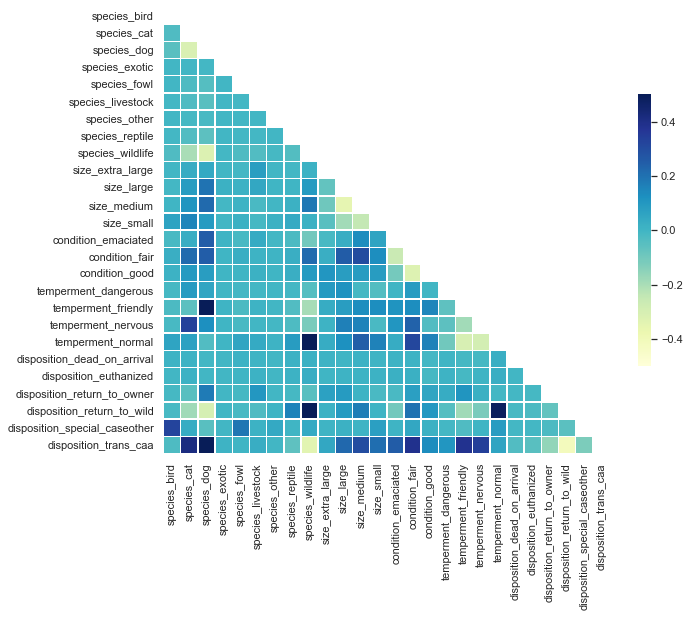

In [113]:
# correlations between species, size, condition, and temperment
corr_plot(ssct_df, minv=-.5, maxv=.5)

It's a lot to look at, but species, size, temperment, condition and disposition. It's a little interesting that dogs are correlated with 'friendly' so much more than cats, who show higher correltions with 'nervous'. 

Do certain types of calls correlate with outcomes?

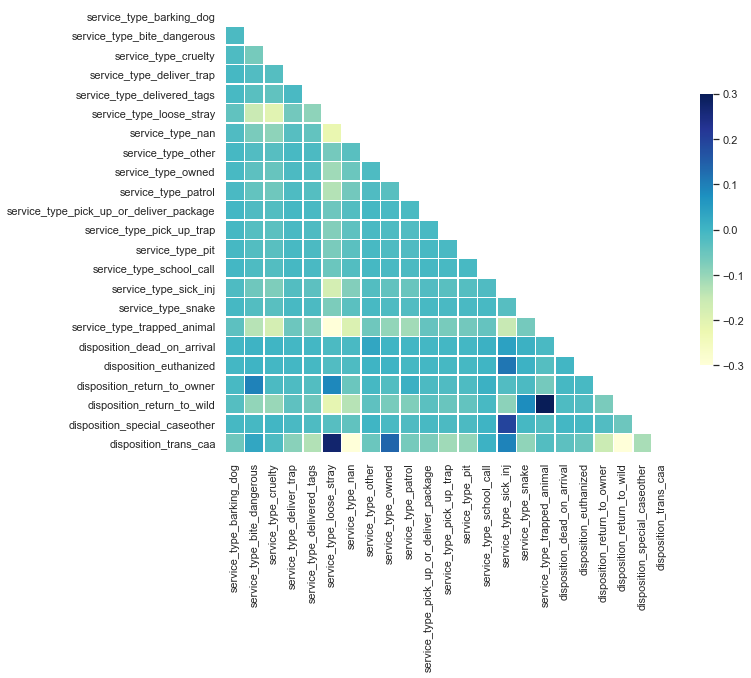

In [114]:
df3 = df[['service_type', 'disposition']]
corr_plot(df3)

The strays/ loose animals correlate highly with being transferred to CAA, and trapped animals with being returned to the wild. There are a few other correlations but nothing that striked me as unusual

# __models__

Models include classification for temperament, disposition(outcome), and a binary classifier for bite/dangerous and not bite/dangerous cases.


* _Yes, it has been brought to my attention that using random grid search and grid search is unusual. I was under the impression that random was for casting a wider net of parameters and grid search was to narrow it down and if done strategically it was more efficient._ 

In [3]:
# import Animal Control Incidents df
df = pd.read_csv('a_control.csv')

for col in ('month', 'weekday'):
    df[col] = df[col].astype(str)

## temperament - accuracy - using GB

*_Excuse the misspelling of 'temperament'(spelled in dataset as 'temperment'). It was overlooked and may not have been correctly edited throughout entire notebook yet_

I'll be using the basic physical characteristics to attempt a classification model of the animal's temperament : friendly, normal, nervous, or dangerous. These are determined by an officer- in the dataset called the 'disposition officer'. I'm unsure of their methods used to identify the animal's temperament, but there could potentially be bias since there could be emotional motivators behind the officer's decision based on their past experiences, subconscious beliefs or prejudices(i.e. large dogs are more likely to be characterized as 'dangerous', than small dogs displaying the same behaviors). With such limited features being included, I'm not expecting high accuracy, but I would think the model could at least do better at classifying than if selected at random.

I'll be using the metric of accuracy to score the model, since the classes aren't extremely unbalanced and I'm not constructing this with the intentions of using it as a safety precaution or situation where recall would be of importance.

### data prep

In [4]:
# selecting only dog species and selecting features
dog_df = df[df['species']=='dog']
dog_df = dog_df[['breed', 'size', 'color', 'temperment' ]]
dog_df=dog_df.dropna()

# assign target
y = dog_df["temperment"]

#remove target from features
dog_df.drop(columns= ['temperment'], axis=1, inplace=True)

# dummy categorical features
col_list = list(dog_df.columns)

# create dummies for categorical features, assign to X
X = pd.DataFrame(pd.get_dummies(data=dog_df, drop_first=True
                   , prefix=col_list))

In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=33)
# assigning test group
actuals=y_test

Since there is a minority and majority group, I'm using both oversampling with synthetic data and random undersampling.

In [10]:
over = SMOTE(sampling_strategy='minority',random_state=3)
under = RandomUnderSampler(sampling_strategy='not minority',random_state=3)
pca = PCA(n_components=.95)

0.9556513824012478


In [11]:
#print (y_train.value_counts())

### default model

In [16]:
# fit default model
xgb_model = Pipeline(steps=[('o', over), ('u', under),('pca', pca), ('x', XGBClassifier(random_state=3))]);

xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

model_report(xgb_model)

Pipeline(memory=None,
         steps=[('o',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=3,
                       sampling_strategy='minority')),
                ('u',
                 RandomUnderSampler(random_state=3, replacement=False,
                                    sampling_strategy='not minority')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('x',
                 XGBClassifier(base_score=...booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               o


Cross Validation Scoring:

train score: 36.61%
test score: 34.92%
cross val score: 32.78%

Classification Report:
              precision    recall  f1-score   support

   dangerous       0.11      0.13      0.12       178
    friendly       0.53      0.31      0.39      2632
     nervous       0.27      0.42      0.33      1326
      normal       0.32      0.38      0.34      1812

    accuracy                           0.35      5948
   macro avg       0.31      0.31      0.30      5948
weighted avg       0.39      0.35      0.35      5948


Confusion matrix:


,pred_friendly,pred_nervous,pred_normal,pred_dangerous
real_friendly,23,26,80,49
real_nervous,75,814,786,957
real_normal,43,257,557,469
real_dangerous,64,444,621,683


With the model overfitting, yet still with such poor performance, I'm not feeling hopeful about significant improvements. After playing with some of the other models, however, this was the most promising.

### random grid

In [17]:
#set random search params
learning_rate=[.009,.01,.25,.2,.15 ,.1]
max_depth = [2,3,50,100,None]
min_child_weight = [.8,1,1.9]
n_estimators = [90,95,100]
gamma = [0.001, 0.002]

random_grid = {
               'x__learning_rate':learning_rate
               ,'x__max_depth': max_depth
               ,'x__min_child_weight':min_child_weight
            ,'x__n_estimators': n_estimators
                , 'x__gamma':gamma
              }

# searching random params - verbose to 10 in anticipation of long wait time
xgb_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=10
                               , random_state=3, n_jobs = -1)
# fit random search model
xgb_random.fit(X_train, y_train)
print('best score: {:.4}%'.format(xgb_random.best_score_ * 100));
print(xgb_random.best_params_);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 22.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 22.2min finished


best score: 34.81%
{'x__n_estimators': 100, 'x__min_child_weight': 1, 'x__max_depth': 3, 'x__learning_rate': 0.009, 'x__gamma': 0.001}


### grid search

In [19]:
param_grid_xgb = [
    {
         'x__gamma':[0,0.009, 0.001],
        'x__min_child_weight': [.9,1,1.1],
    'x__learning_rate': [0.009,0.008, 0.007],
    'x__n_estimators': [100,150,200],
    'x__max_depth': [3,4,5,6]
    }
]

# Construct Grid Search
gs_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb
                    ,scoring='accuracy',cv=5, n_jobs=-1, verbose=10)

# Fit using grid search
gs_xgb.fit(X, y)

# Best accuracy and parameters
print('best score: {:.3}%'.format(gs_xgb.best_score_ * 100))
print('params:\n', gs_xgb.best_params_);

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 46.3min finished


best score: 34.5%
params:
 {'x__gamma': 0.001, 'x__learning_rate': 0.008, 'x__max_depth': 4, 'x__min_child_weight': 1, 'x__n_estimators': 150}


### final model

In [20]:
# fit using best params
xgb_gs_model = XGBClassifier(gamma=0.001,
                            learning_rate=0.008,
                             max_depth=4,
                             min_child_weight=1,
                             n_estimators=150)
xgb_gs_model.fit(X_train, y_train)

predictions = xgb_gs_model.predict(X_test)

model_report(xgb_gs_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001,
              learning_rate=0.008, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Cross Validation Scoring:

train score: 45.07%
test score: 44.65%
cross val score: 44.6%

Classification Report:
              precision    recall  f1-score   support

   dangerous       0.00      0.00      0.00       178
    friendly       0.45      0.99      0.62      2632
     nervous       0.43      0.03      0.06      1326
      normal       0.44      0.01      0.02      1812

    accuracy                           0.45      5948
   macro avg       0.33      0.26      0.17      5948
weighted avg       0.43      0.45      0.29      5948


Confusion matrix:


,pred_friendly,pred_nervous,pred_normal,pred_dangerous
real_friendly,0,174,4,0
real_nervous,0,2596,24,12
real_normal,0,1273,40,13
real_dangerous,0,1767,25,20


44.65% isn't ideal, but is a 10% improvement.

* note that other models were attempted and can be found in separate notebook. I can only assume it's the data presented that isn't adequate in predicting the temperament of the animals. Gathering more data- less surface features and more background- is where I would start in attempt to improve accurracy

## disposition - macro recall - using GB

With this model, I'm hoping to classify the outcomes of the animal control cases. In most cases, the animal gets held for 3-5 days, then transferred to the CAA, where a number of resolutions can come from there. For the days that the case is in the hands of ACRC, the usual outcomes are, other than being transferred, being returned to the owner or wildnerness, being euthanized, or finding the animal dead upon arrival. If able to tune a decent model, it could be implemented to help call takers prioritize the dispatch of officers to cases where there's high possibility of being a dead on arrival animal. It could also help to have an idea of what the facility should be prepared for, like making sure they have a kennel or medical treatment on immediately avaialble upon the animal's arrival to the center.

I've used macro recall as the target score metric, as this would be a matter of safety. Responding to calls in a more immediate manner when anticipating a near death case, even if more often than not there was not a state of urgency for the animal's well being is not an issue so much as it is to respond to every call with equal priority and risk an animal's safety. Of course, dead upon arrival is not the only possible outcome, awareness of other anticipated outcomes could prove to be helpful for preparation and efficiency reasons.

### data prep

In [22]:
dis_df = df[['breed', 'size', 'color', 'month', 'species','municipality'
         , 'service_type', 'disposition']]

In [23]:
dis_df.dropna(axis=0, inplace=True)

# # assign target
y = dis_df["disposition"]

#remove target from features
dis_df.drop(columns= ['disposition'], axis=1, inplace=True)

# # dummy categorical features
# #col_list = list(df.select_dtypes(include=['object']).columns)
col_list = list(dis_df.columns)

# create dummies for categorical features, assign to X
X = pd.DataFrame(pd.get_dummies(data=dis_df, drop_first=True
                   , prefix=col_list))
#X = dis_df

In [24]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)
actuals=y_test

In [25]:
y_train.value_counts()

trans_caa            23390
return_to_wild        6426
return_to_owner       1216
special_caseother      598
euthanized             109
dead_on_arrival         52
Name: disposition, dtype: int64

The extreme imbalance, especially in the minority classes, will likely be an obstacle in the model's performance, even with the resampling. 

In [26]:
over = SMOTE(sampling_strategy='minority',random_state=3)
under = RandomUnderSampler(sampling_strategy='not minority',random_state=3)
pca = PCA(n_components=.95)

0.9507757201753749


### default model

In [27]:
#initialize and fit gradient boost
gbt_model = Pipeline(steps=[('o', over), ('u', under),('pca', pca), ('g', GradientBoostingClassifier(random_state=3))]);
gbt_model.fit(X_train, y_train);

predictions = gbt_model.predict(X_test)
model_report(gbt_model);

Pipeline(memory=None,
         steps=[('o',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=3,
                       sampling_strategy='minority')),
                ('u',
                 RandomUnderSampler(random_state=3, replacement=False,
                                    sampling_strategy='not minority')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('g',
                 GradientBoostingClassif...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                       


Cross Validation Scoring:

train score: 50.89%
test score: 49.33%
cross val score: 48.36%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.01      0.44      0.03        27
  return_to_owner       0.08      0.53      0.13       304
   return_to_wild       0.87      0.82      0.84      1607
special_caseother       0.07      0.42      0.12       149
        trans_caa       0.94      0.41      0.57      5848

         accuracy                           0.49      7948
        macro avg       0.33      0.44      0.28      7948
     weighted avg       0.87      0.49      0.60      7948


Confusion matrix:


,pred_dead_on_arrival,pred_euthanized,pred_special_caseother,pred_return_to_owner,pred_return_to_wild,pred_trans_caa
real_dead_on_arrival,0,6,3,1,3,0
real_euthanized,1,12,4,1,6,3
real_special_caseother,1,21,162,12,21,87
real_return_to_owner,8,99,45,1312,109,34
real_return_to_wild,0,45,7,9,63,25
real_trans_caa,1,656,1932,167,720,2372


### random grid

In [29]:
# setting parameters for random search
learning_rate=[0.05,.1, .15,1]
loss = ['deviance', 'exponential']
max_depth = [None,3,5,10,20,25,30] 
n_estimators = [50,100,200,250,300,350]
min_samples_split = [2,3,4,5]
min_samples_leaf = [1,2,3,4,5]
min_weight_fraction_leaf = [0,0.0001,1]

random_grid = {'g__learning_rate':learning_rate,
               'g__loss': loss,
               'g__max_depth': max_depth,
               'g__n_estimators': n_estimators,
               'g__min_samples_split': min_samples_split,
               'g__min_samples_leaf': min_samples_leaf,
               'g__min_weight_fraction_leaf': min_weight_fraction_leaf
               }

#searching random params
gbt_random = RandomizedSearchCV(estimator = gbt_model, param_distributions = random_grid
                               , n_iter = 100, cv = 5, verbose=8
                               , scoring='recall_macro', random_state=3, n_jobs = -1)

# fit random search model
gbt_random.fit(X_train, y_train);
print('best score: {:.4}%'.format(gbt_random.best_score_ * 100));
print('params:\n', gbt_random.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 11.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('o',
                                              SMOTE(k_neighbors=5, n_jobs=None,
                                                    random_state=3,
                                                    sampling_strategy='minority')),
                                             ('u',
                                              RandomUnderSampler(random_state=3,
                                                                 replacement=False,
                                                                 sampling_strategy='not '
                                                                                   'minority')),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                  

best score: 43.36%
params:
 {'g__n_estimators': 110, 'g__min_weight_fraction_leaf': 0.0001, 'g__min_samples_split': 3, 'g__min_samples_leaf': 5, 'g__max_depth': 20, 'g__loss': 'deviance', 'g__learning_rate': 0.15}


### grid search

In [31]:
# grid search params and run search
param_grid_gbt = [
    {'g__n_estimators': [110,120,200],
     'g__min_weight_fraction_leaf':[0,0.00009, 0.0001],
    'g__learning_rate': [0.1, 0.15, 0.2],
    'g__min_samples_split': [2,3,4],
    'g__min_samples_leaf': [4,5,6,7],
    'g__max_depth': [None,15, 20, 25]
    }]

# grid search
gs_gbt = GridSearchCV(estimator=gbt_model,param_grid=param_grid_gbt,
                    scoring='recall_macro',cv=3, n_jobs=-1, verbose=2)
# fit grid search
gs_gbt.fit(X_train, y_train);

# best params
print('best score: {:.4}%'.format(gs_gbt.best_score_ * 100))
print('params:\n', gs_gbt.best_params_)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 80.5min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed: 93.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('o',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=3,
                                              sampling_strategy='minority')),
                                       ('u',
                                        RandomUnderSampler(random_state=3,
                                                           replacement=False,
                                                           sampling_strategy='not '
                                                                             'minority')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.95,
                                            random_state=None,
                                    

best score: 44.88%
params:
 {'g__learning_rate': 0.1, 'g__max_depth': 20, 'g__min_samples_leaf': 6, 'g__min_samples_split': 2, 'g__min_weight_fraction_leaf': 9e-05, 'g__n_estimators': 110}


### final model

In [32]:
# fitting best params
gbt_gs_model = GradientBoostingClassifier(learning_rate=0.1,
                                         max_depth=20,
                                         min_samples_leaf=6,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.00009,
                                         n_estimators=110)
gbt_gs_model.fit(X_train, y_train)

predictions = gbt_gs_model.predict(X_test)

model_report(gbt_gs_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=20,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=6, min_samples_split=2,
                           min_weight_fraction_leaf=9e-05, n_estimators=110,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Cross Validation Scoring:

train score: 95.61%
test score: 91.65%
cross val score: 91.21%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.00      0.00      0.00        27
  return_to_owner       0.23      0.05      0.08       304
   return_to_wild       0.92      0.97      0.95      1607
special_caseother       0.53      0.32      0.39       149
        trans_caa       0.93      0.97      0.95      5848

         accuracy                           0.92      7948
        macro avg       0.44      0.38      0.39      7948
     weighted avg       0.89      0.92      0.90      7948


Confusion matrix:


,pred_dead_on_arrival,pred_euthanized,pred_special_caseother,pred_return_to_owner,pred_return_to_wild,pred_trans_caa
real_dead_on_arrival,0,0,1,2,1,9
real_euthanized,0,0,1,2,0,24
real_special_caseother,0,0,14,14,0,276
real_return_to_owner,0,1,5,1556,6,39
real_return_to_wild,0,0,2,12,47,88
real_trans_caa,3,7,38,98,35,5667


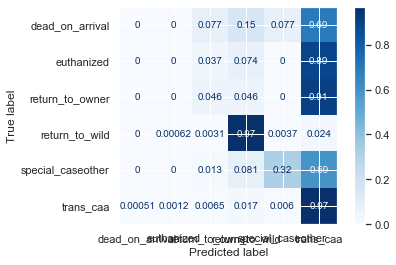

In [39]:
#disp = 
plot_confusion_matrix(gbt_gs_model, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize='true')


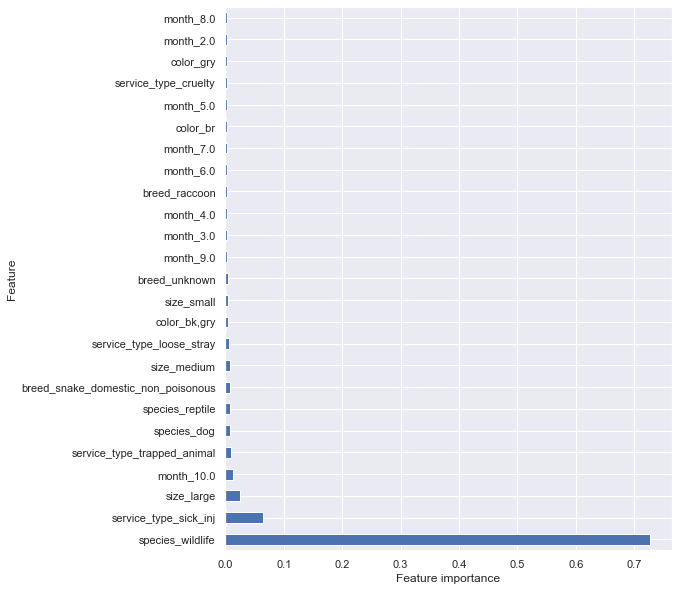

In [35]:
plot_feats(gbt_gs_model)

## biting/dangerous - macro f1 - using ADA 

Here , I've divided the classes into bite cases, or cases labeled as 'dangerous', and 'non-dangerous/non bite-case'. As most predictive features provided, once again are only a few describing physical characteristics, I anticipate limitations to the model. For a better   

### data prep

In [40]:
# selecting 
b_df = df[df['species']=='dog']

b_df = b_df[['breed', 'size', 'color', 'service_type']]

for word in ('loose_stray', 'sick_inj', 'owned', 'trapped_animal', 'patrol', 'school_call'
            ,'other', 'pit', 'snake', 'pick_up_trap', 'cruelty'):
    b_df['service_type'] = b_df['service_type'].replace(word, 'not_bite/dang')

b_df=b_df.dropna()

In [41]:
# # assign target
y = b_df["service_type"]

#remove target from features
b_df.drop(columns= ['service_type'], axis=1, inplace=True)

# dummy categorical features
#col_list = list(df.select_dtypes(include=['object']).columns)
col_list = list(b_df.columns)

# create dummies for categorical features, assign to X
X = pd.DataFrame(pd.get_dummies(data=b_df, drop_first=True, prefix=col_list))
# X = b_df

In [42]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=33)
actuals=y_test

In [43]:
over = SMOTE(random_state=3)
pca = PCA(n_components=.95)

0.9501117052775215


### default model

In [52]:
#initialize and fit default model
ada_model = Pipeline(steps=[('o', over),('pca', pca), ('a', AdaBoostClassifier(random_state=3))])
ada_model.fit(X_train, y_train)

predictions = ada_model.predict(X_test);
model_report(ada_model, label=('bite', 'not_bite'))

Pipeline(memory=None,
         steps=[('o',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=3,
                       sampling_strategy='auto')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('a',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=50,
                                    random_state=3))],
         verbose=False)


Cross Validation Scoring:

train score: 71.41%
test score: 69.77%
cross val score: 69.42%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.13      0.42      0.20       541
 not_bite/dang       0.93      0.72      0.81      5492

      accuracy                           0.70      6033
     macro avg       0.53      0.57      0.51      6033
  weighted avg       0.86      0.70      0.76      6033


Confusion matrix:


,not_bite,bite
not_bite,229,312
bite,1512,3980


### random grid

In [49]:
#set random search params
learning_rate= [.09,.1,1,1.5,2]
n_estimators = [50,100,200,600]

random_grid = {'a__learning_rate':learning_rate,
               'a__n_estimators': n_estimators }

#random grid search
ada_random = RandomizedSearchCV(estimator = ada_model
                               , param_distributions = random_grid
                               , n_iter = 10, cv = 5, verbose=7, scoring='recall_macro'
                               , random_state=3, n_jobs = -1)
# Fit the random search model
ada_random.fit(X_train, y_train)

print('best score: {:.4}%'.format(ada_random.best_score_ * 100))
print('params:\n', ada_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('o',
                                              SMOTE(k_neighbors=5, n_jobs=None,
                                                    random_state=3,
                                                    sampling_strategy='auto')),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=0.95,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('a',
                                              AdaBoostClassifier(algorithm='SAMME.R',
                      

best score: 57.58%
params:
 {'a__n_estimators': 500, 'a__learning_rate': 1.5}


### grid search

In [56]:
#grid search params and fitting grid search
param_grid_ada = [
    {'a__n_estimators': [450,500,550,600],
    'a__learning_rate': [1.5, 2,2.5]}]

# Construct Grid Search
gs_ada = GridSearchCV(estimator=ada_model,param_grid=param_grid_ada,
                    scoring='recall_macro',cv=5, n_jobs=-1, verbose=2)

# Fit using grid search
gs_ada.fit(X_train, y_train);

# Best accuracy and parameters
print('best score: {:.4}%'.format(gs_ada.best_score_ * 100))
print('params:\n', gs_ada.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 50.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('o',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=3,
                                              sampling_strategy='auto')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.95,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('a',
                                        AdaBoostClassifier(algorithm='SAMME.R',
                                                           base_estimator=None,
                                                           learning_rate=1.0

best score: 57.61%
params:
 {'a__learning_rate': 1.5, 'a__n_estimators': 600}


### final model

In [57]:
# fit best params
ada_gs_model = AdaBoostClassifier(n_estimators=600,
                                  learning_rate=1.5)
ada_gs_model.fit(X_train, y_train);

predictions = ada_gs_model.predict(X_test)

model_report(ada_gs_model)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.5,
                   n_estimators=600, random_state=None)


Cross Validation Scoring:

train score: 91.04%
test score: 90.95%
cross val score: 90.96%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.22      0.00      0.01       541
 not_bite/dang       0.91      1.00      0.95      5492

      accuracy                           0.91      6033
     macro avg       0.57      0.50      0.48      6033
  weighted avg       0.85      0.91      0.87      6033


Confusion matrix:


,pred_not_bite/dang,pred_bite_dangerous
real_not_bite/dang,2,539
real_bite_dangerous,7,5485


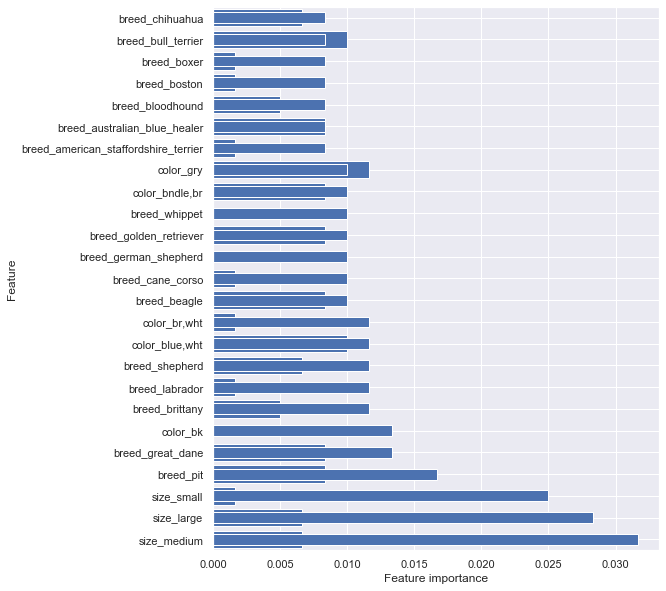

In [58]:
plot_feats(ada_gs_model)
#plot_matrix(ada_gs_model)

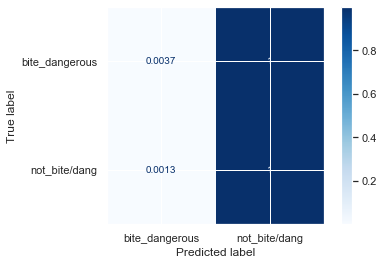

In [59]:
plot_confusion_matrix(ada_gs_model, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize='true');

____

# __Conclusion__

__Data Cleaning/ Exploration__

I found some challenges when cleaning the data. The most disappointing was the amount of missing values and unusable features. Although nothing looked out of the ordinary with the time data , the dates were somewhat of a mystery to me. The incident dates showed a period of time with extremely elevated incident rates that I can't come up with an explanation for. The color features were difficult and I'm not sure I cleaned that column the most efficient way possible, although I did reduce the unique values from 1800 to 100. Most of the cleaning was simply editting spellings and removing unnecessary characters. I merged columns 'service_code' and 'request_type', which may have been better left separate, as the service code was given by the officer and the request type was provided by the caller, so it may have been interesting to explore the possibility of differences there.

__Classification Models__

I used SMOTE oversampling and Random undersampling to balance train sets for models due to the extreme imbalance. This caused some overfitting, but even so, models performed significantly better for the individual classes.

After fitting several models and selecting the best fits for the target metrics, none of the models performed impressively. Separate notebooks containing many trials and failures are in repo.

The first classification model was targeting the temperament of the animal using it's physical characteristics and was not a success. I used accuracy for scoring, due to the unimportance of any class over the other. Of course, of all the classification models, this had the worst accuracy rates with little improvement from tuning.

The second model was classifying disposition, and I used macro recall as the metric. These models also did not perform well. The last one, biting/dangerous vs' not dangerous, at least showed decent improvement from the default model using AdaBoost, but still not to a degree worth using. 



__Problems/Future Work__

I can only infer that the data was not the appropriate content in making these classifications. Gathering more data or improving the quality of data in some other way is a possibility if I were to pursue this. I would consider joining a dataset, or find information necessary to provide sufficent data on features I wasn't able to use in the models and exploration. For one, using data from the CAA would present a better understanding of the full process of animal control and rescues procedure. The outcome of the animals proceeding impounding would be more useful in drawing more meaningful conclusions as well.